In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
cd ..

/userdata/jgauthier/projects/ideal-word-representations


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import re
from typing import Union, Callable

from src.utils import concat_csv_with_indices

In [6]:
df = concat_csv_with_indices("outputs/notebooks/librispeech-train-clean-100/**/word_discrimination/map_scores.csv",
                        [lambda p: p.parents[1].name,
                         lambda p: p.parents[2].name, lambda p: p.parents[3].name,
                         lambda p: p.parents[4].name],
                        ["equivalence", "model", "base_model", "dataset"]).reset_index()

df["trace"] = df.base_model + "/" + df.model + "/" + df.equivalence

In [7]:
predictions_df = concat_csv_with_indices("outputs/notebooks/librispeech-train-clean-100/**/word_discrimination/predictions.csv",
                        [lambda p: p.parents[1].name,
                         lambda p: p.parents[2].name, lambda p: p.parents[3].name,
                         lambda p: p.parents[4].name],
                        ["equivalence", "model", "base_model", "dataset"]).reset_index()

predictions_df["trace"] = predictions_df.base_model + "/" + predictions_df.model + "/" + predictions_df.equivalence

In [22]:
# estimate chance performance for word recognition at each dataset + frame
chance_performance = {}
for dataset, dataset_results in predictions_df.groupby("dataset"):
    # take any trace; they're all the same
    chance_df = next(iter(dataset_results.groupby("trace")))[1]
    # words should all be balanced in this evaluaton, so we can take the mean of relative word frequency
    chance_performance[dataset] = chance_df.groupby("frame_idx").apply(lambda x: x.label.value_counts(normalize=True).mean()).rename("chance_performance")
chance_performance = pd.concat(chance_performance, names=["dataset"])
chance_performance

/tmp/ipykernel_3189479/1243191981.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  chance_performance[dataset] = chance_df.groupby("frame_idx").apply(lambda x: x.label.value_counts(normalize=True).mean()).rename("chance_performance")


dataset                      frame_idx
librispeech-train-clean-100  0            0.000500
                             1            0.000502
                             2            0.000527
                             3            0.000695
                             4            0.001054
                             5            0.001764
                             6            0.003185
                             7            0.006897
                             8            0.013333
                             9            0.043478
                             10           0.090909
                             11           0.250000
                             12           0.500000
                             13           1.000000
Name: chance_performance, dtype: float64

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

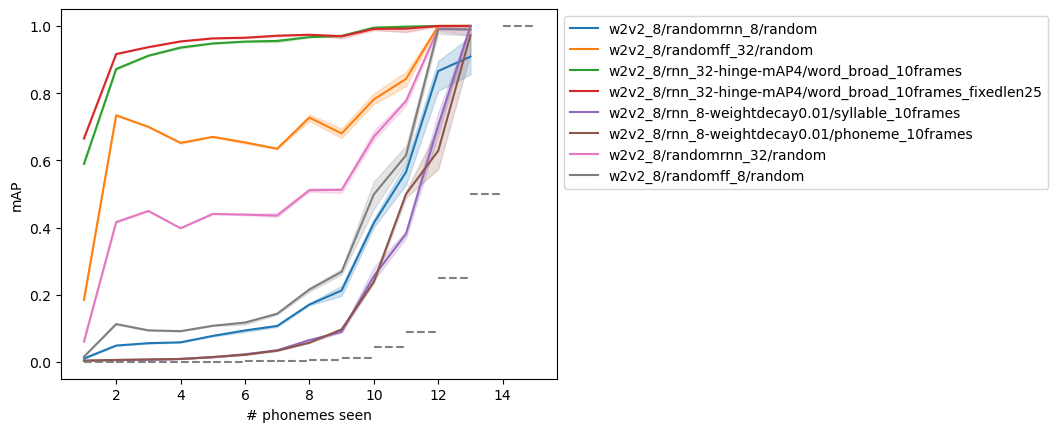

In [23]:
plot_dataset = "librispeech-train-clean-100"

ax = sns.lineplot(data=df[df.dataset == plot_dataset], x="num_frames", y="mAP", hue="trace")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax.set_xlabel("# phonemes seen")

# draw chance performance as a horizontal line over each x value
for frame, frame_chance_perf in chance_performance.loc[plot_dataset].items():
    ax.plot([frame + 1, frame + 2], [frame_chance_perf, frame_chance_perf],
            color="gray", linestyle="--")

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

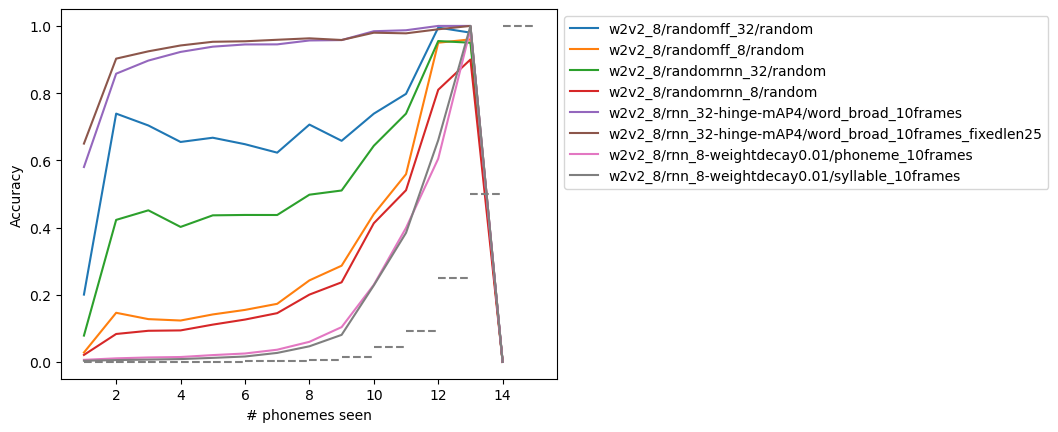

In [28]:
acc_df = predictions_df.loc[predictions_df.dataset == plot_dataset].groupby(["trace", "frame_idx"]).correct.mean().reset_index()
acc_df["num_frames"] = acc_df.frame_idx + 1
ax = sns.lineplot(data=acc_df,
             x="num_frames", y="correct", hue="trace")

ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax.set_xlabel("# phonemes seen")
ax.set_ylabel("Accuracy")

# draw chance performance as a horizontal line over each x value
for frame, frame_chance_perf in chance_performance.loc[plot_dataset].items():
    ax.plot([frame + 1, frame + 2], [frame_chance_perf, frame_chance_perf],
            color="gray", linestyle="--")